# 演算法 Midterm Project: Mechanical parts (Bolt, Nut, Washer, Pin) 

109403019 鄒翔宇

辨識工具:

- Bolt - 螺栓
- Locating Pin - 定位插栓
- Nut - 螺帽
- Washer - 墊圈

預期結果:
- Training Accuracy >= 99%
- Valiation Accuracy >= 97%

## 1. 導入套件

In [19]:
import os  # os 模組，用於操作文件和目錄
import zipfile  # zipfile 模組，用於讀寫 ZIP 文件
import random  # random 模組，用於生成隨機數
import numpy as np  # numpy 模組，用於數組和矩陣運算

import tensorflow as tf  # tensorflow 模組，用於機器學習和深度學習
from tensorflow import keras  # keras 模組，用於建構模型
from keras import layers  # layers 模組，用於定義深度學習模型的各層
from keras.models import Sequential  # Sequential class, 用於建構網路架構
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, Flatten # 各種 Keras 層，用於構建卷積神經網絡
from keras.regularizers import l2  # l2 正則化，用於防止Overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Keras 回調函數，用於在訓練過程中監控模型表現並進行相應調整

from PIL import Image  # PIL 模組，用於處理圖像

from matplotlib import pyplot as plt  # pyplot 模組，用於繪製圖表

## 2. 取得資料集


- 從Google Drive下載資料集並解壓縮。參考 [colab 上傳文件 - csdn](https://blog.csdn.net/little_yueyue/article/details/117793421) 以及助教提供的方法

In [20]:
!gdown https://drive.google.com/uc?id=1qCHfycy91EyUFzilBvxu8hYVYp0l6jCh  --output /tmp/MidTerm_Dataset.zip 

Downloading...
From: https://drive.google.com/uc?id=1qCHfycy91EyUFzilBvxu8hYVYp0l6jCh
To: /tmp/MidTerm_Dataset.zip
100% 50.4M/50.4M [00:00<00:00, 188MB/s]


In [21]:
local_zip='/tmp/MidTerm_Dataset.zip'
zip_ref=zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

檢查一下資料集中的所有資料夾

In [22]:
def walk_through_dir(directory_name):
    for dirpaths,dirnames,filenames in os.walk(directory_name):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpaths}'")

In [23]:
train_dir='../tmp/MidTerm_Dataset/Train'
test_dir='../tmp/MidTerm_Dataset/Test'

In [24]:
walk_through_dir(train_dir)

There are 4 directories and 0 images in '../tmp/MidTerm_Dataset/Train'
There are 0 directories and 1523 images in '../tmp/MidTerm_Dataset/Train/bolt'
There are 0 directories and 1523 images in '../tmp/MidTerm_Dataset/Train/nut'
There are 0 directories and 1523 images in '../tmp/MidTerm_Dataset/Train/locatingpin'
There are 0 directories and 1523 images in '../tmp/MidTerm_Dataset/Train/washer'


In [25]:
walk_through_dir(test_dir)

There are 4 directories and 0 images in '../tmp/MidTerm_Dataset/Test'
There are 0 directories and 381 images in '../tmp/MidTerm_Dataset/Test/bolt'
There are 0 directories and 381 images in '../tmp/MidTerm_Dataset/Test/nut'
There are 0 directories and 381 images in '../tmp/MidTerm_Dataset/Test/locatingpin'
There are 0 directories and 381 images in '../tmp/MidTerm_Dataset/Test/washer'


## 3. 視覺化資料集

- 隨機選取資料集中的圖片，確認一下圖片長怎樣以及有沒有問題

In [26]:
# 從指定路徑下隨機顯示total_number張圖片
def plot_random_image(target_dir, total_number=5):

  # 隨機取得total_number張圖片
  target_class=random.choice(os.listdir(target_dir))
  target_folder=os.path.join(target_dir, target_class)
  random_image=random.sample(os.listdir(target_folder), 5)

  # 顯示total_number張圖片
  plt.figure(figsize=(16, 5))
  row = int(total_number ** (1/2))
  for i in range(total_number):
    plt.subplot(row, 5, i+1)
    img=tf.io.read_file(os.path.join(target_folder, random_image[i]))

    img=tf.io.decode_image(img)
    plt.imshow(img)
    plt.title(f'{target_class}\n{img.shape}')
    plt.axis(False)

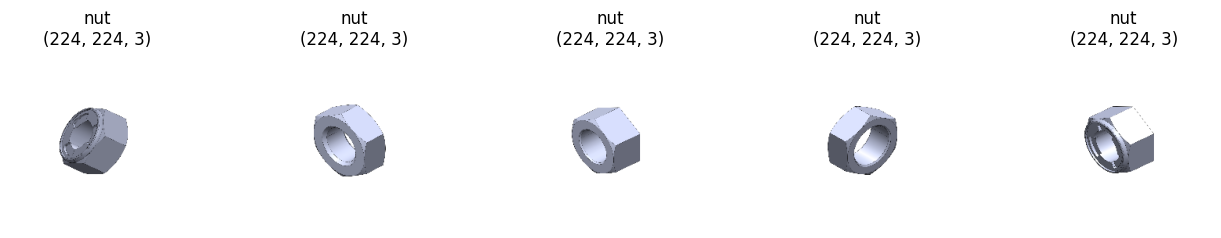

In [27]:
plot_random_image(train_dir)

## 4. 資料預處理

- 將訓練及以及測試集根據資料夾名稱做分類

- 將訓練集中的資料打亂以獲取更好的訓練效果

In [28]:
image_size = (224, 224) # 依照資料集中所有的圖片大小做設定

train_data=tf.keras.preprocessing.image_dataset_from_directory(
  directory=train_dir,
  label_mode="categorical",
  image_size=image_size,
  color_mode="rgb", # Default value: "rgb"
  batch_size=32,  # Default value: 32
  shuffle=True, # 打亂資料，減少樣本之間的相關性，可以獲得比較好的效果，預設為 True
)
class_names=train_data.class_names
num_classes=len(class_names)


test_data=tf.keras.preprocessing.image_dataset_from_directory(
  directory=test_dir,
  label_mode="categorical",
  image_size=image_size,
  color_mode="rgb", # Default value: "rgb"
  batch_size=32,  # Default value: 32
  shuffle=False, # 不打亂資料
)


Found 6092 files belonging to 4 classes.
Found 1524 files belonging to 4 classes.


## 5. 建立模型

模型建立keras官方文件: https://keras.io/guides/sequential_model/


卷積層數量三層貌似比四層好

In [49]:
input_shape = (224, 224, 3)

def create_model(input_shape, num_classes):

  model = keras.Sequential(
    [     
        
      Conv2D(filters=32, kernel_size=(3, 3), activation= "relu", input_shape=input_shape), # 卷積層，提取特徵
      BatchNormalization(), # 批量標準化層，用於加速訓練並提高模型性能
      MaxPooling2D(pool_size=(2, 2)), # 最大池化層，保留主要特徵
     
      Conv2D(filters=64, kernel_size=(3, 3), activation= "relu"),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),

      Conv2D(filters=128, kernel_size=(3, 3), activation= "relu"),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),

      Flatten(),  # 展平層，將卷積層的特徵圖展平為一維向量
      Dense(256,activation="relu", kernel_regularizer=l2(0.001)), # 全連接層，使用L2正則化以防止過擬合
      Dropout(0.5), # Dropout層，減少過擬合，隨機丟棄一定比例的神經元
      Dense(num_classes, activation='softmax')   # 輸出層，使用Softmax激活函數，對應各個類別的概率
    ]
  )

  return model

model=create_model(input_shape, num_classes)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_7 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

## 6. 制定訓練計畫

- 編譯模型
- 把前處理好的資料丟進模型開始訓練

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# 添加早停回調防止過擬合
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 64

history_of_model = model.fit(train_data,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
191/191 [==============================] - 19s 83ms/step - loss: 0.1472 - accuracy: 0.9997 - val_loss: 0.2131 - val_accuracy: 0.9816
Epoch 2/20
191/191 [==============================] - 16s 83ms/step - loss: 0.1265 - accuracy: 0.9992 - val_loss: 0.2115 - val_accuracy: 0.9770
Epoch 3/20
191/191 [==============================] - 16s 83ms/step - loss: 0.1220 - accuracy: 0.9977 - val_loss: 0.2048 - val_accuracy: 0.9790
Epoch 4/20
191/191 [==============================] - 16s 83ms/step - loss: 0.1190 - accuracy: 0.9977 - val_loss: 0.1983 - val_accuracy: 0.9810
Epoch 5/20
191/191 [==============================] - 16s 85ms/step - loss: 0.1155 - accuracy: 0.9987 - val_loss: 0.2015 - val_accuracy: 0.9777
Epoch 6/20
191/191 [==============================] - 16s 82ms/step - loss: 0.1128 - accuracy: 0.9992 - val_loss: 0.1772 - val_accuracy: 0.9843
Epoch 7/20
191/191 [==============================] - 16s 83ms/step - loss: 0.1102 - accuracy: 0.9990 - val_loss: 0.1964 - val_accuracy:

## 7. 評估模型

- 顯示模型成效
- 顯示訓練過程的優化曲線

In [64]:
score=model.evaluate(test_data, verbose=0)
print('Test lose:', score[0])
print('Test Accuracy:', score[1])

Test lose: 0.17291387915611267
Test Accuracy: 0.9835957884788513


In [65]:
def plot_loss_curves(history):
  train_loss=history.history['loss']
  val_loss=history.history['val_loss']

  train_accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs=range(1,len(history.history['loss'])+1)
  plt.figure(figsize=(20,7))
  # plot loss data
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")
  plt.title("Train Loss History curves")
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  # plt.show()

  # plot accuracy data
  plt.subplot(1,2,2)
  plt.plot(epochs,train_accuracy,label="training_acc")
  plt.plot(epochs,val_accuracy,label="validation_acc")
  plt.title("Train Accuracy History Curves")
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.legend()

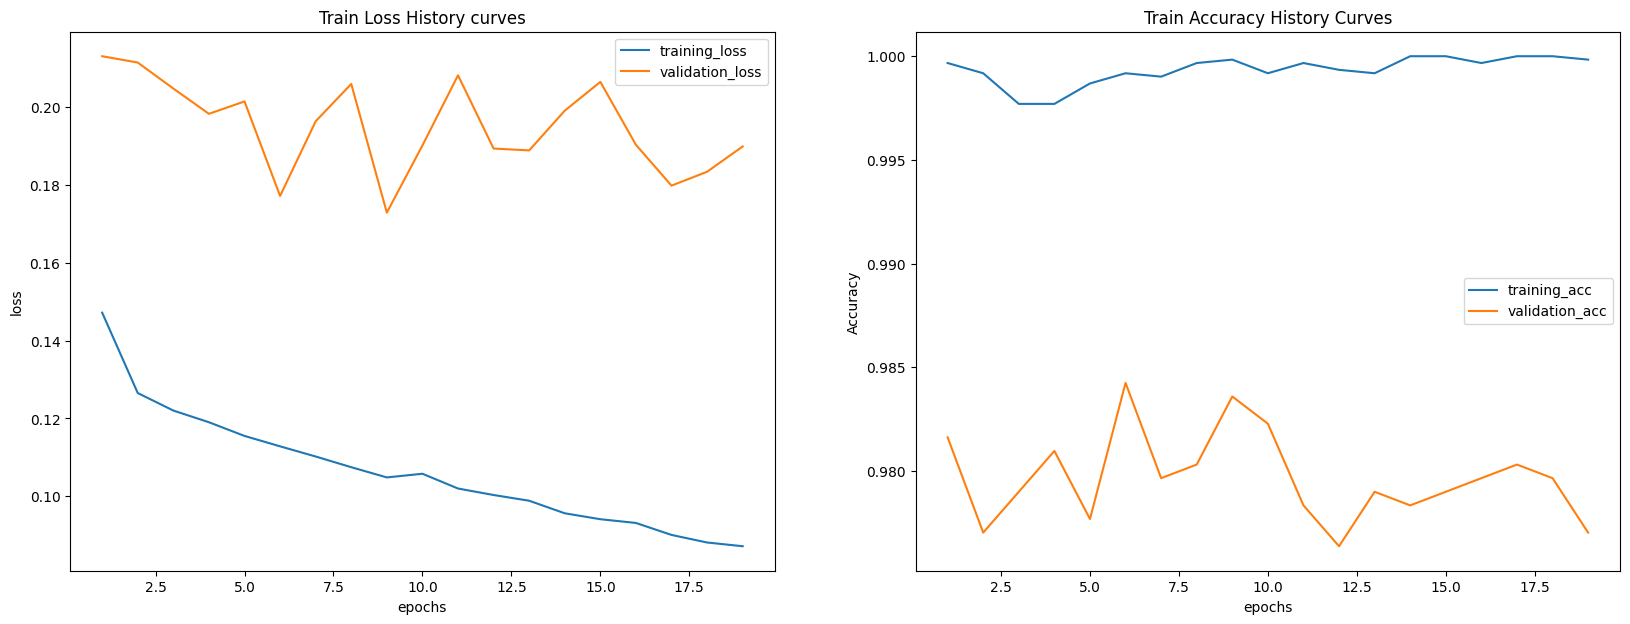

In [66]:
plot_loss_curves(history_of_model)

## 8. 做預測

- 隨機選取25張圖片進行預測

In [67]:
def predict_random_mechanical_parts(target_dir, model, total_number=25):
  # 隨機取得total_number張圖片
  random_images = []
  for _ in range(total_number):
    target_class = random.choice(os.listdir(target_dir))
    target_folder = os.path.join(target_dir, target_class)
    random_image = random.choice(os.listdir(target_folder))
    random_images.append((target_class, random_image))

  # 顯示total_number圖片
  plt.figure(figsize=(16, 16))
  row = int(total_number ** (1/2))
  count_correct = 0
  for i, (target_class, random_image) in enumerate(random_images):
    plt.subplot(row, 5, i + 1)
    img = tf.io.read_file(os.path.join(target_dir, target_class, random_image))

    img = tf.io.decode_image(img)
    plt.imshow(img)

    # 對圖片進行預處理，使其適合輸入到模型中
    preprocessed_img = tf.expand_dims(img, axis=0)

    # 進行預測
    pred = model.predict(preprocessed_img)[0]  # 回傳針對不同class的預測值
    predicted_class_index = np.argmax(pred)
    predicted_class_name = class_names[predicted_class_index]
    if target_class == predicted_class_name:
      count_correct = count_correct + 1
    plt.title(f'True: {target_class}\nPredicted: {predicted_class_name}\n{img.shape}')
  
  plt.tight_layout(pad=2.0)
  print('Prediction Accuracy: ' + str(round((count_correct / total_number * 100), 2)) + '%')

1/1 [==============================] - 0s 22ms/step
Prediction Accuracy: 100.0%


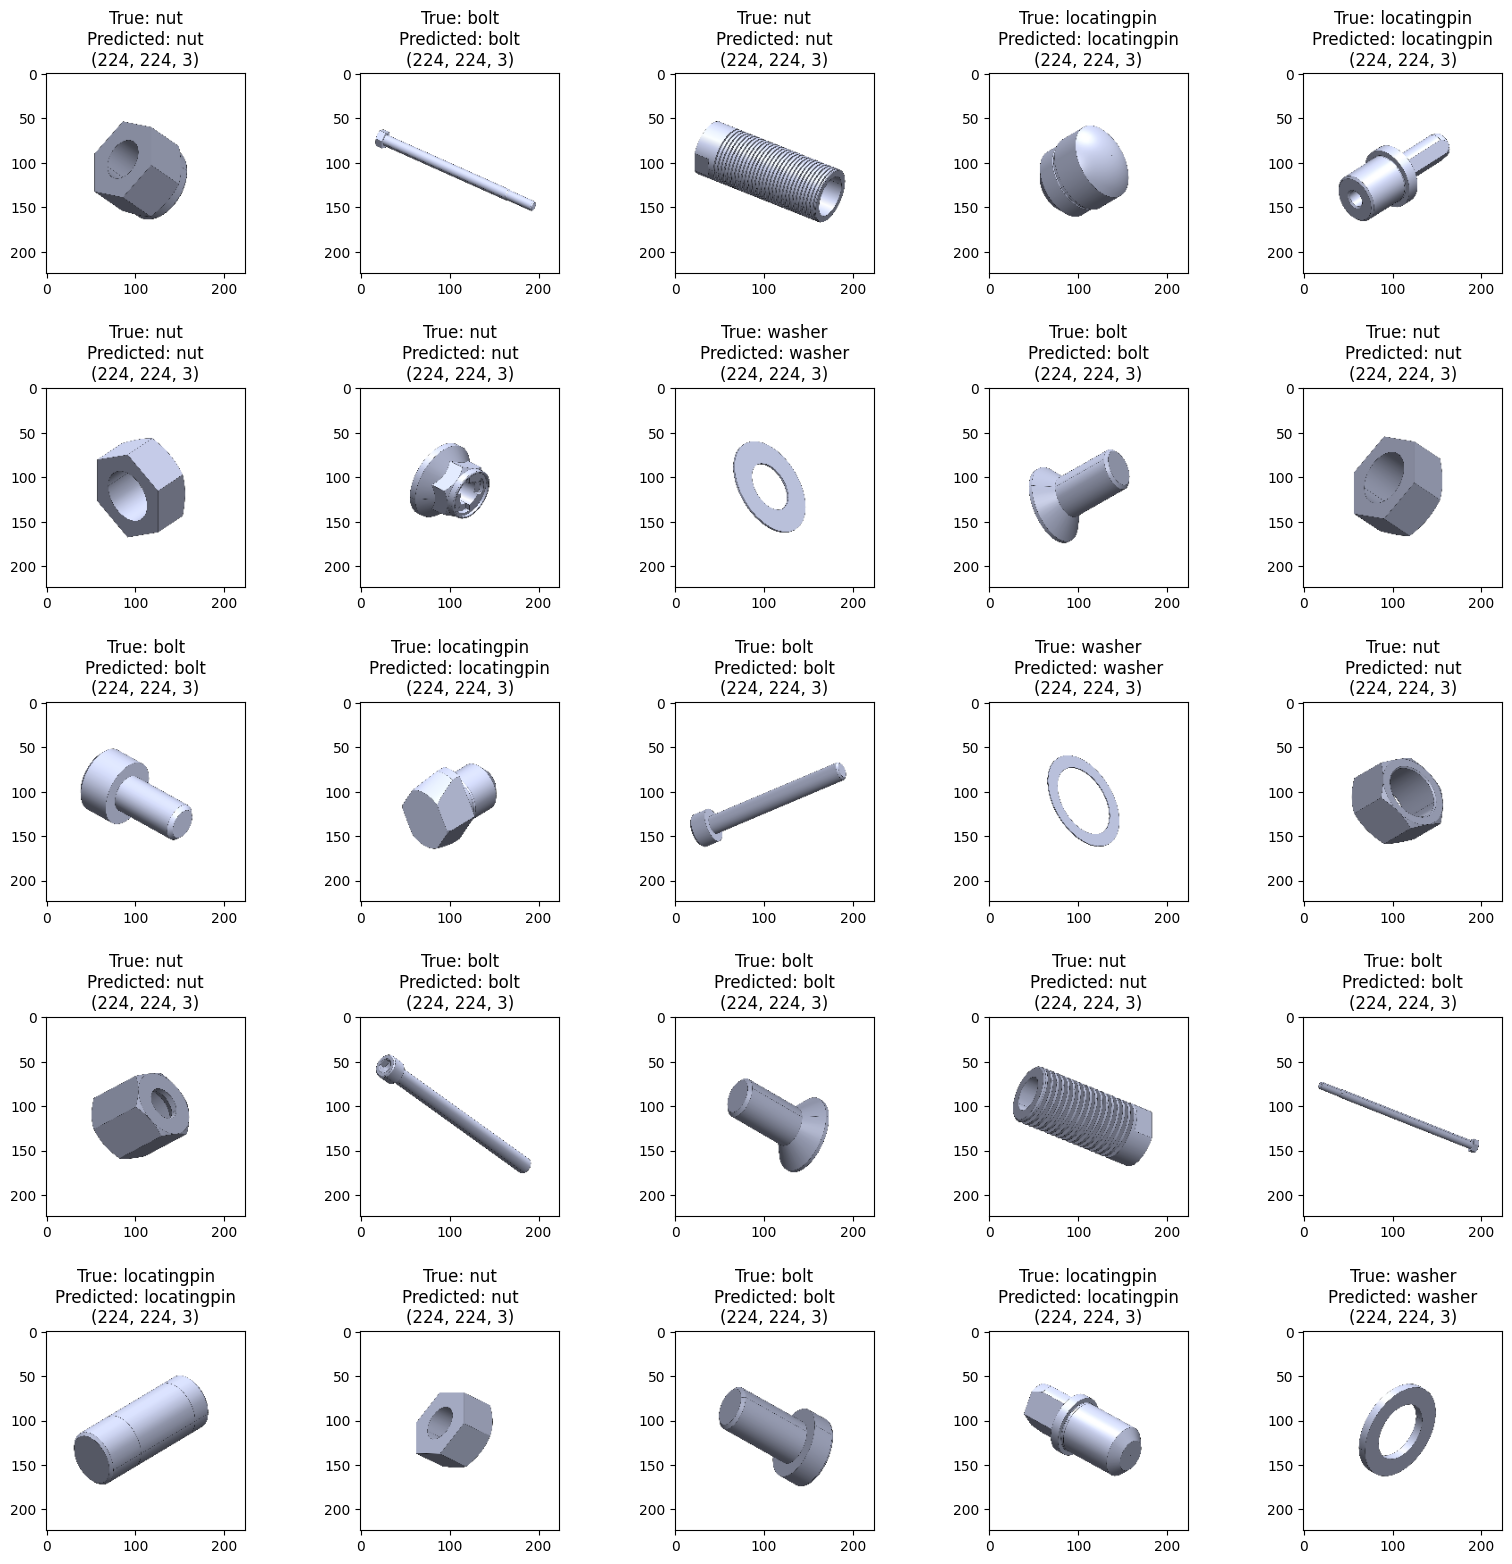

In [69]:
predict_random_mechanical_parts(target_dir=test_dir, model=model)

## 參考資料

- [colab 上傳資料 - csdn ](https://blog.csdn.net/little_yueyue/article/details/117793421)
- [Keras API reference](https://keras.io/api/)